# Mapping lineage-traced cells across time points with moslin

In this tutorial, we showcase using **lineage** and **gene expression** information to link cells across time points with [moslin](https://github.com/theislab/moslin) {cite}`lange-moslin:23`. Lineage information is important to regularize the mapping problem as it enables us to uncover complex cellular state-change trajectories.

:::{seealso}
- See {doc}`../examples/problems/600_leaf_distance` on how to compute distances along a lineage tree. 
- See {doc}`200_temporal_problem` on how to link cells across time points without lineage information. 
:::

## The `moslin` method

:::{figure-md} fig-motivation

<img src="../../_static/img/100_lineage/moslin_motivation.jpg" alt="motivation" width="400px">

**Mapping cells across time points:** moslin {cite}`lange-moslin:23` helps to infer ancestor and descendant relationships for rare or transient cell types. This and other concept figures in this notebook have been created using BioRender. 
:::

High-diversity lineage relationships can be recorded using evolving barcoding systems {cite}`wagner:2020`; when applied in-vivo, these record independent lineage relationships in each individual. To infer the molecular identity of putative ancestor states, samples need to be related from early to late time points. 

:::{figure-md} fig-experimental

<img src="../../_static/img/100_lineage/moslin_ice.jpg" alt="independent clonal resampling" width="400px">

**Mapping independent clonal evolution:** evolving lineage recording systems, based on, e.g., Cas-9 induced genetic scars {cite}`spanjaard:18,alemany:18,raj:18`, record independent clonal evolution in each individual.
:::

 In our setting, each individual corresponds to a different time point, and we wish to relate cells across time to infer precise differentiation trajectories {cite}`forrow:21`. While gene expression is directly comparable across time points, lineage information is not: individual lineage trees may be reconstructed at each time point {cite}`spanjaard:18,alemany:18,raj:18,jones:20`, but these do not uncover the molecular identity of putative ancestors or descendants.

:::{figure-md} fig-concept

<img src="../../_static/img/100_lineage/moslin_concept.jpg" alt="moslin's objective function" width="800px">

**The moslin algorithm**: the grey outline represents a simplified state manifold, dots and triangles illustrate early and late cells, respectively, and colors indicate cell states.
:::

Critically, moslin {cite}`lange-moslin:23` uses two sources of information to map cells across time in an optimal transport (OT) formulation {cite}`peyre:19`:

- **gene expression**: directly comparable across time points, included in a Wasserstein (W)-term {cite}`schiebinger:19`. The W-term compares individual early and late cells and seeks to minimize the distance cells travel in phenotypic space. 
- **lineage information**: not directly comparable across time points, included in a Gromov-Wasserstein (GW)-term {cite}`nitzan:19,peyre:2016`. The GW-term compares pairwise early and late cells and seeks to maximize lineage concordance.

We combine both sources of information in a Fused Gromov-Wasserstein (FGW) problem {cite}`vayer:2020`, a type of OT-problem. Additionally, we use entropic regularization {cite}`cuturi:2013` to speed up computations and to improve the statistical properties of the solution {cite}`peyre:19`. In the objective function, we compare $N$ early to $M$ late cells. We use the following definitions: 

- $a$ and $b$: marginal distributions over early and late cells, respectively, representing any prior knowledge, including growth and death rates. 
- $P \in \mathbb{R}^{N \times M}$: coupling matrix we seek to learn; it probabilistically relates early to late cells. 
- $C$: cost matrix between early and late cells; it quantifies how "expensive" it is to move along the phenotypic landscape. Typically, it represents Euclidean distance in a gene expression-based latent space like PCA or scVI {cite}`lopez2018deep`. 
- $C^X$ and $C^Y$: cost matrices among early and late cells, respectively. These quantify lineage similarity among cells from one time point. Typically, they represent either the scaled [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) among barcodes ({class}`~moscot.costs.BarcodeDistance`) or the shortest path distance along reconstructed lineage trees ({class}`~moscot.costs.LeafDistance`). 
- $H(P)$: entropy of the coupling matrix {cite}`cuturi:2013`. 
- $\varepsilon$: weight given to entropic regularitation. Larger values will lead to more "blurred" couplings. 
- $\alpha$: weight given to OT (gene expression) vs. GW (lineage information) terms.

Under the hood, `moslin` {cite}`lange-moslin:23` is based on {mod}`~moscot`; we use the {class}`~moscot.problems.time.LineageProblem` to solve the Fused-Gromov Wasserstein {cite}`vayer:2020` problem of relating lineage and gene expression across time. In this tutorial, we demonstrate `moslin` on TedSim-simulated {cite}`pan:22` data.

## Preliminaries

In [1]:
import warnings
from typing import List, Literal, Optional, Tuple

import moscot as mt
import moscot.plotting as mtp
import ot
import tqdm
from moscot.problems.time import LineageProblem, TemporalProblem

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt

import scanpy as sc
from anndata import AnnData

warnings.simplefilter("ignore", UserWarning)

### Define utility functions

Iterate over the rows or columns in two coupling matrices and compute the [earth mover's distance (EMD)](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). 

In [2]:
def compute_w2(
    p_1: np.ndarray,
    p_2: np.ndarray,
    cost: np.ndarray,
    metric_type: Literal["descendant", "ancestor"],
    scale_by_marginal: bool = True,
) -> List[float]:
    errors = []

    # transpose for ancestors
    if metric_type == "ancestor":
        p_1 = p_1.T
        p_2 = p_2.T

    # iterate over all cells
    for i in tqdm.tqdm(range(p_1.shape[0])):
        # normalize to get distributions
        marginal = p_1[i].sum()
        dist_1 = p_1[i] / marginal
        dist_2 = p_2[i] / p_2[i].sum()

        # compute the EMD distance between the ground-truth and the prediction
        error, log = ot.emd2(
            dist_1.astype(float), dist_2.astype(float), cost.astype(float), log=True
        )

        # append the EMD (potentially scaled by the marignal)
        if log["warning"] is None:
            if scale_by_marginal:
                errors.append(marginal * error)
            else:
                errors.append(error)
        else:
            errors.append(np.nan)

    return errors

Obtain RNA-based cost matrices at early and late time points from an {class}`~anndata.AnnData` object. 

In [3]:
def get_cost(
    adata: AnnData,
    early_tp: float = 8,
    late_tp: float = 12,
    time_key: str = "time",
    rep: str = "X_pca",
    n_dim: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    # retrieve cost matrices
    embedding = np.asarray(adata.obsm[rep], dtype=float)

    # make sure we have enough dimensions
    if n_dim is None:
        n_dim = embedding.shape[1]
    elif embedding.shape[1] < n_dim:
        raise ValueError(f"You only have {embedding.shape[1]} dimensions in {rep}.")
    embedding = embedding[:, :n_dim]

    # restrict to early and late cells
    mask_early, mask_late = (
        adata.obs[time_key] == early_tp,
        adata.obs[time_key] == late_tp,
    )
    embedding_early, embedding_late = embedding[mask_early], embedding[mask_late]

    # compute the corresponding distance matrices
    cost_early = euclidean_distances(embedding_early, squared=True)
    cost_late = euclidean_distances(embedding_late, squared=True)

    return cost_early, cost_late

Compute ancestor and descendant error between two couplings, where one typically corresponds to the ground-truth. 

In [4]:
def compute_errors(
    adata: AnnData,
    p_1: np.ndarray,
    p_2: np.ndarray,
    early_tp: float = 8,
    late_tp: float = 12,
    time_key: str = "time",
    rep: str = "X_pca",
    n_dim: Optional[int] = None,
    scale_by_marginal: bool = True,
) -> Tuple[List[float], List[float]]:
    # check that the shapes match
    assert p_1.shape == p_2.shape

    # retrieve early and late cost matrices
    cost_early, cost_late = get_cost(
        adata=adata,
        early_tp=early_tp,
        late_tp=late_tp,
        time_key=time_key,
        rep=rep,
        n_dim=n_dim,
    )

    # compute the ancestor errors
    ancestor_errors = compute_w2(
        p_1=p_1,
        p_2=p_2,
        cost=cost_early,
        metric_type="ancestor",
        scale_by_marginal=scale_by_marginal,
    )

    # compute the descendant errors
    descendant_errors = compute_w2(
        p_1=p_1,
        p_2=p_2,
        cost=cost_late,
        metric_type="descendant",
        scale_by_marginal=scale_by_marginal,
    )

    return ancestor_errors, descendant_errors

### Dataset description

This data has been simulated using TedSim {cite}`pan:22`; it captures a simple branching differentiation process as depicted in the state tree below. TedSim simulates cell division events from a root cell up to the observed cells; it simultaneously generates a heritable lineage barcode and a gene expression profile for each cell. 

:::{figure-md} fig-state-tree

<img src="../../_static/img/100_lineage/tedsim_state_tree.jpg" alt="TedSim state tree" width="400px">

**TedSim state tree**: cells are sampled from the differentiation trajectory defined via this tree.
:::

The {func}`~moscot.datasets.tedsim` simulated dataset {cite}`pan:22` includes:

- {attr}`obs['time'] <anndata.AnnData.obs>`, representing time-point information for cells at depth `8` (early) and `12` (late). 
- {attr}`obsm['barcodes'] <anndata.AnnData.obsm>`, providing the TedSim-simulated barcodes per cell. 
- {attr}`obsp['cost_matrices'] <anndata.AnnData.obsp>`, containing precomputed lineage cost matrices for depth `8` and `12` cells based on the barcodes ({class}`~moscot.costs.BarcodeDistance`).

### Data loading

We download the data from figshare (approx. 50MB). 

In [5]:
adata = mt.datasets.tedsim()
adata

AnnData object with n_obs × n_vars = 8448 × 500
    obs: 'parent', 'depth', 'cellID', 'time', 'state', 'time_point'
    uns: 'cluster_colors', 'couplings', 'metadata', 'state_colors', 'tree'
    obsm: 'barcodes'
    obsp: 'cost_matrices'

### Preprocessing

Basic preprocessing to obtain a PC representation of the data. 

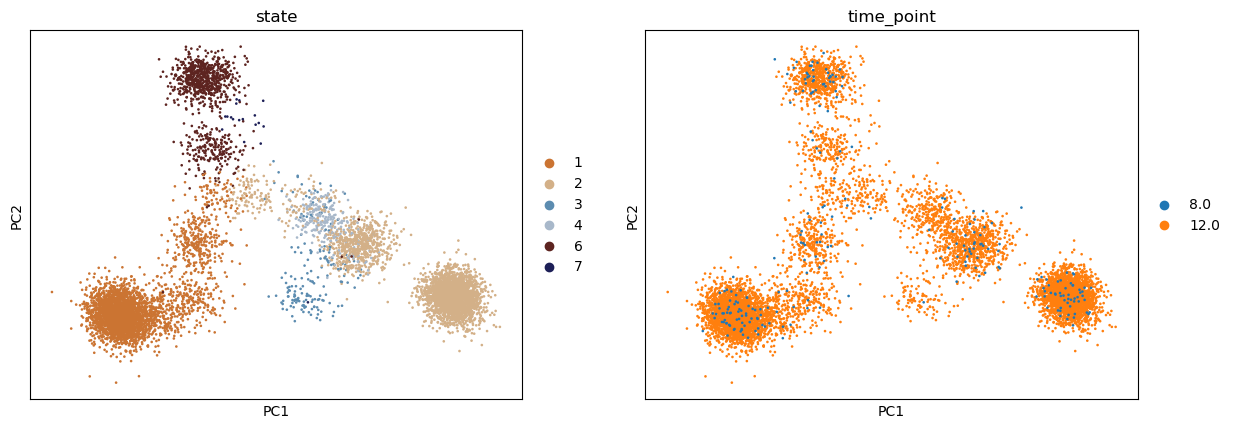

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata, random_state=0)

sc.pl.pca(adata, color=["state", "time_point"])

## Prepare the {class}`~moscot.problems.time.LineageProblem`

We need to define the cost matrices, the marginals, and a few more parameters. 

:::{figure-md} fig-workflow
<img src="../../_static/img/100_lineage/moslin_pipeline.jpg" alt="inputs and outputs" width="800px">

**Algorithm inputs and outputs:** we need to define the cost matrices for gene expression ($C$) and lineage information ($C^X, C^Y$), the marginals ($a$ and $b$), the weight given to entropic regularization ($\varepsilon>0$) and the gene expression/lineage contribution parameter $\alpha \in (0, 1]$. `moslin` yields a coupling matrix $P$ which may be further analyzed using either {mod}`moscot` directly (as shown below), or using [CellRank](https://cellrank.readthedocs.io/en/latest/) {cite}`lange:22`. 
:::

We pass this information through the {class}`~anndata.AnnData` object:

- `time_key`: defines the {attr}`obs <anndata.AnnData.obs>` column for the temporal information.
- `joint_attr`: defines how gene expression distances across time points should be computed for $C$. We use squared Euclidean distance in the PCA space computed above. 
- `lineage_attr`: defines how lineage distances should be computed for $C^X, C^Y$. In our case, we have precomputed cost matrices, so we just point to the corresponding {attr}`obsp <anndata.AnnData.obsp>` field. 
If we did not have precomputed cost matrices, we could also set the `lineage_attr` to `{'attr': 'obsm', 'key': 'barcodes', 'cost': 'barcode_distance'}`, which computes the cost matrices based on the barcodes ({class}`~moscot.costs.BarcodeDistance`).

We define the $\alpha$ and $\varepsilon$ below. 

In [7]:
lp = LineageProblem(adata)
lp = lp.prepare(
    time_key="time",
    joint_attr="X_pca",
    lineage_attr={"attr": "obsp", "key": "cost_matrices", "cost": "custom"},
)

## Solve the {class}`~moscot.problems.time.LineageProblem`

We choose a large value for $\alpha$ to emphasize lineage information, and a small value for $\varepsilon$ to obtain a crips transport map. Additionally, we allow a bit of unbalancedness {cite}`chizat:18,sejourne:21` to accommodate varying cell-type proportions at the two time points by setting $\tau_a < 1$ {cite}`schiebinger:19`. The two parameters $\tau_a$ and $\tau_b$, both in $(0, 1]$, control the degree of unbalancedness for early and late cells, respectively. 

In [8]:
lp = lp.solve(alpha=0.99, epsilon=1e-3, tau_a=0.99)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


## Analyzing cell type transitions

Now, we can compute the descendants of cells at time point `8`, aggregated by cell type. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`, corresponding to early and late cells, respectively. 

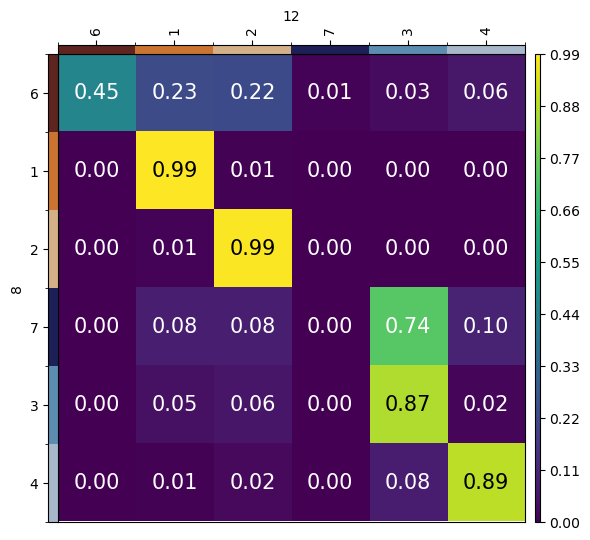

In [9]:
order = ["6", "1", "2", "7", "3", "4"]

cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups={"state": order},
    target_groups={"state": order},
    forward=True,
    key_added="lp_transitions",
)

mtp.cell_transition(lp, fontsize=15, figsize=(5, 5), key="lp_transitions")

Another way to visualize cell type transitions is by plotting a [Sankey diagram](https://en.wikipedia.org/wiki/Sankey_diagram) from source to target cells.

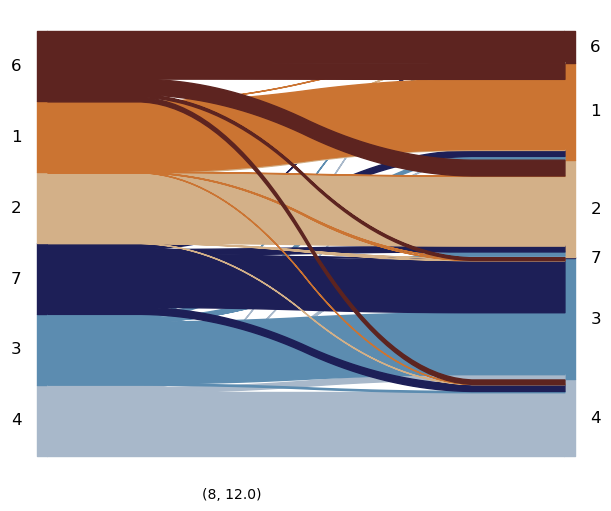

In [10]:
lp.sankey(
    source=8,
    target=12,
    source_groups={"state": order[::-1]},
    target_groups={"state": order[::-1]},
)
mtp.sankey(lp, figsize=(6, 5))

## Compare with the ground-truth and gene expression baseline

Based on the lineage tree that TedSim {cite}`pan:22` creates for the simulation, we can obtain the ground-truth coupling from early to late cells. Additionally, and as a baseline, we can just use a W-term to link cells across the two time points based on similar gene expression with the {class}`~moscot.problems.time.TemporalProblem`. Using this method, we ignore the additional lineage information. 

Let's see whether lineage information gets us closer to the ground-truth. We start by extracting it from the {class}`~anndata.AnnData` object. 

In [11]:
coupling_gt = adata.uns["couplings"]["true"].astype(float)

For the gene expression (W-term) baseline, create a {class}`~moscot.problems.time.TemporalProblem`, prepare it using the same PCA representation as above, and solve it, using the same parameters as above. 

In [12]:
tp = TemporalProblem(adata)
tp = tp.prepare(time_key="time", joint_attr="X_pca")
tp = tp.solve(epsilon=1e-3, tau_a=0.99)

# compute the aggregated transition matrix
cell_transition = tp.cell_transition(
    source=8,
    target=12,
    source_groups={"state": order},
    target_groups={"state": order},
    forward=True,
    key_added="tp_transitions",
)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


For the ground-truth solution, we instantiate a {class}`~moscot.problems.time.TemporalProblem` as well, but pass the precomputed coupling matrix, representing the ground-truth link of early to late cells. 

In [13]:
# instantiate a dummy problem for this
gt = TemporalProblem(adata).prepare(time_key="time", joint_attr="X_pca")

# pass the ground-truth solution
gt[8, 12].set_solution(coupling_gt)

# compute the aggregated transition matrix
cell_transition = gt.cell_transition(
    source=8,
    target=12,
    source_groups={"state": order},
    target_groups={"state": order},
    forward=True,
    key_added="gt_transitions",
)

Let's visualize the three cases jointly. 

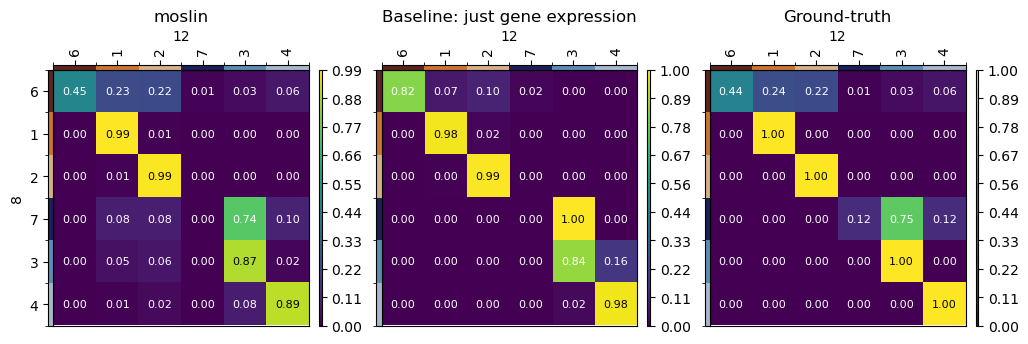

In [14]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

# moslin
axes[0] = mtp.cell_transition(
    lp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    key="lp_transitions",
)

# baseline OT
axes[1] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    key="tp_transitions",
)

# ground-truth
axes[2] = mtp.cell_transition(
    gt,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[2],
    key="gt_transitions",
)

fig.subplots_adjust(wspace=0.2)

# add some titles
axes[2].axes[4].set_title("moslin")
axes[2].axes[7].set_title("Baseline: just gene expression")
axes[2].axes[10].set_title("Ground-truth")

# remove some repeated y-labels and ticks
axes[2].axes[8].set_ylabel("")
axes[2].axes[8].set_yticks([])
axes[2].axes[11].set_ylabel("")
axes[2].axes[11].set_yticks([])

plt.show()

We quantify the difference between known ground-truth transitions, and the predictions computed using `moslin` and the {class}`~moscot.problems.time.TemporalProblem`, by computing ancestor and descendant errors. Briefly, following {cite}`forrow:21`, for every early and late cell, we compute its predicted descendant and ancestor distribution, respectively, and compare with ground-truth. To quantify discrepancies between predicted and ground-truth ancestor/descendant distributions, we use the [Earth mover's distance (EMD)](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). 

In [15]:
# retrieve the coupling matrices
coupling_moslin = np.asarray(lp.solutions[8, 12].transport_matrix, dtype=float)
coupling_ot = np.asarray(tp.solutions[8, 12].transport_matrix, dtype=float)
coupling_outer = np.asarray(adata.uns["couplings"]["independent"], dtype=float)

# compute errors for moslin
anc_moslin, desc_moslin = compute_errors(adata, p_1=coupling_moslin, p_2=coupling_gt)

# compute errors for the OT approach
anc_ot, desc_ot = compute_errors(adata, p_1=coupling_ot, p_2=coupling_gt)

# compute errors for an uninformative coupling as baseline
anc_outer, desc_outer = compute_errors(adata, p_1=coupling_outer, p_2=coupling_gt)

100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [01:27<00:00,  2.92it/s]


To obtain an interpretable number between $0$ (ground-truth) and $1$ (uninformative), we average the EMD discrepancies for ancestor and descendant distributions over all cells, normalize with an uninformative coupling, and take the mean over ancestor and descendant errors for both methods. To obtain an uninformative coupling, we simply take the outer product of the two marginals $a$ and $b$. Intuitively, you could think of this as random guessing in a way that respects the marginals. 

The final metric is in $[0, 1]$, the lower the better. 

In [16]:
mean_error_moslin = (
    np.mean(anc_moslin) / np.mean(anc_outer)
    + np.mean(desc_moslin) / np.mean(desc_outer)
) / 2
mean_error_ot = (
    np.mean(anc_ot) / np.mean(anc_outer) + np.mean(desc_ot) / np.mean(desc_outer)
) / 2

print(
    f"Mean error moslin = {mean_error_moslin:.2f}, mean error OT = {mean_error_ot:.2f}."
)

Mean error moslin = 0.32, mean error OT = 0.60.


`moslin`'s {cite}`lange-moslin:23` performance on this dataset is much better, compared to the baseline {class}`~moscot.problems.time.TemporalProblem` that is based on gene expression only. 

### Zoom into one subpopulation

Across all cells in this dataset, we've seen above that `moslin` achieves a much better performance compared to a baseline W-term approach for predicting ancestors and descendants of depth 12 and 8 cells, respectively. Let's zoom in to visualize what this means for a particular {ref}`cell state <fig-state-tree>`. We compute descendant populations via the {meth}`push-forward <moscot.problems.time.LineageProblem.push>` operation. 

In [17]:
common_kwargs = {
    "source": 8,
    "target": 12,
    "data": "state",
    "subset": "6",
    "return_data": True,
}

# compute the descendant distribution for either approach
lp_push = lp.push(key_added="lp_transitions", **common_kwargs)
tp_push = tp.push(key_added="tp_transitions", **common_kwargs)
gt_push = gt.push(key_added="gt_transitions", **common_kwargs)

# write them to `.obs`
time_points = adata.obs["time_point"].cat.categories
adata.obs["lp_push"], adata.obs["tp_push"], adata.obs["gt_push"] = [None] * 3

for t in time_points:
    mask = adata.obs["time_point"] == t

    adata.obs.loc[mask, "lp_push"] = np.asarray(lp_push[t].flatten(), dtype=float)
    adata.obs.loc[mask, "tp_push"] = np.asarray(tp_push[t].flatten(), dtype=float)
    adata.obs.loc[mask, "gt_push"] = np.asarray(gt_push[t].flatten(), dtype=float)

We first {func}`visualize <moscot.plotting.push>` the cells of the state we are interested in. We highlight cells from time point 8 with larger cirles, and the source state in color. We would like to see where this state is mapped to at time point 12 using either approach. 

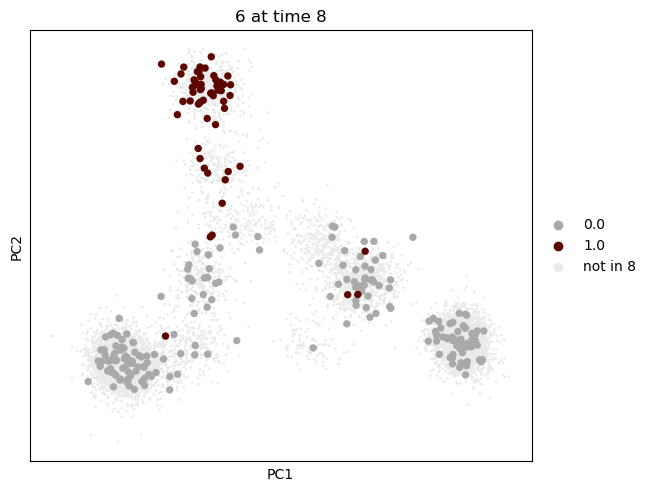

In [18]:
mtp.push(
    lp,
    time_points=[8],
    key="lp_transitions",
    ax=axes[0],
    basis="pca",
    dot_scale_factor=8,
)

We visualilze the descendant distributions we obtain from `moslin` and the baseline {class}`~moscot.problems.time.TemporalProblem` and compare with the ground-truth. 

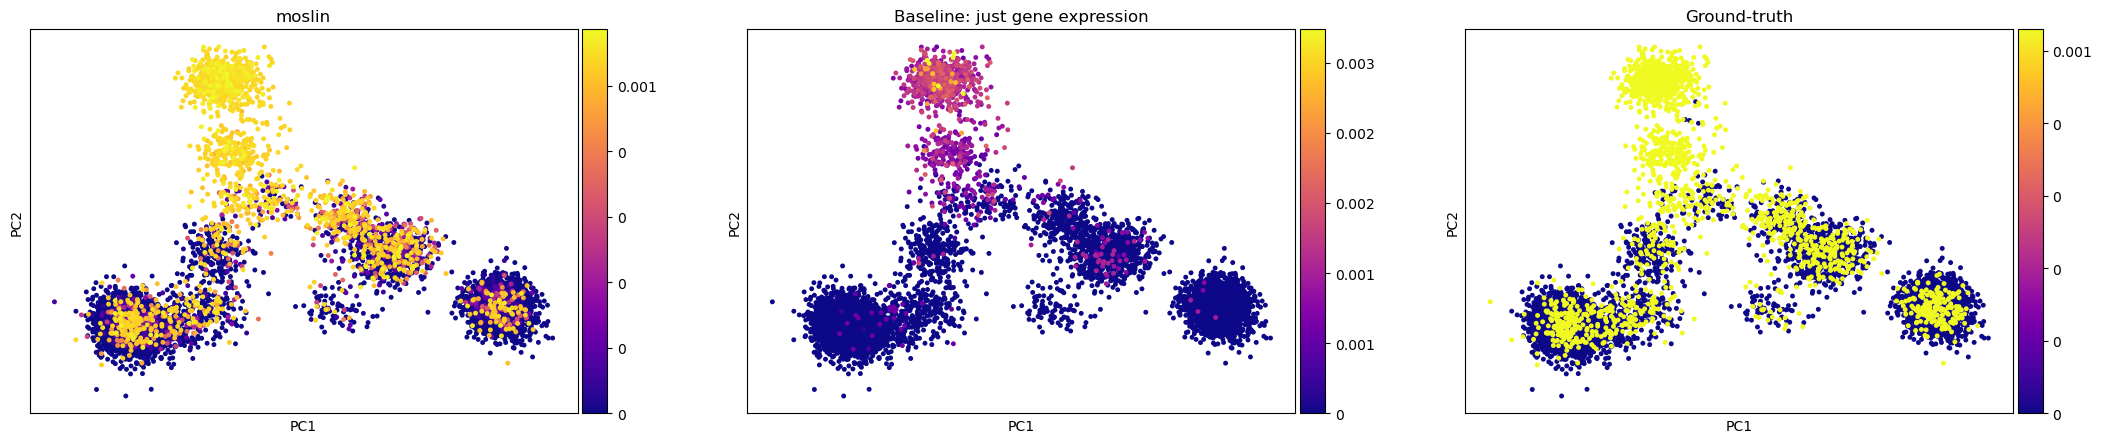

In [19]:
mask = adata.obs["time_point"] == 12.0

sc.pl.scatter(
    adata[mask],
    basis="pca",
    color=["lp_push", "tp_push", "gt_push"],
    size=50,
    color_map="plasma",
    title=["moslin", "Baseline: just gene expression", "Ground-truth"],
)

`moslin`'s {cite}`lange-moslin:23` predicted descendant distribution for this state is visually much more similar to ground-truth compared to what the baseline {class}`~moscot.problems.time.TemporalProblem` gives us without lineage information. 